In [1]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings
import numpy as np
import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [3]:
arr1 = [pyemma.coordinates.load(f'../features_v1/contacts_v1_{i:03d}.npy') for i in range(9)]

In [4]:
arr2 = [pyemma.coordinates.load(f'../features_v1/coord_v1_{i:03d}.npy') for i in range(9)]

In [5]:
arr3 = [pyemma.coordinates.load(f'../features_v1/t_new_{i:03d}.npy') for i in range(9)]

In [6]:
arr4 = [pyemma.coordinates.load(f'../features_v1/ca_com_v1_{i:03d}.npy') for i in range(9)]

In [7]:
arr5 = [pyemma.coordinates.load(f'../features_v1/torsions_v1_{i:03d}.npy') for i in range(9)]

In [8]:
arr6 = [pyemma.coordinates.load(f'../features_v1/ca_v1_{i:03d}.npy') for i in range(9)]

In [9]:
combo_all = [np.concatenate([a1, a2, a3, a4, a5, a6], axis=1) for a1, a2, a3, a4, a5, a6 in zip(arr3, arr4, arr2, arr1, arr5, arr6)]


In [10]:
combo_ext = [np.concatenate([a1, a2, a3, a4], axis=1) for a1, a2, a3, a4 in zip(arr3, arr4, arr2, arr1)]


Now we have to start loading these into tICA


In [32]:
labels = ['contacts','coordination','heavy dists','ca COM dists','torsions','ca-ca','combo-all','comba-ext']

[5.525439754556248]
[4.812801943923747]
[4.244289832918599]


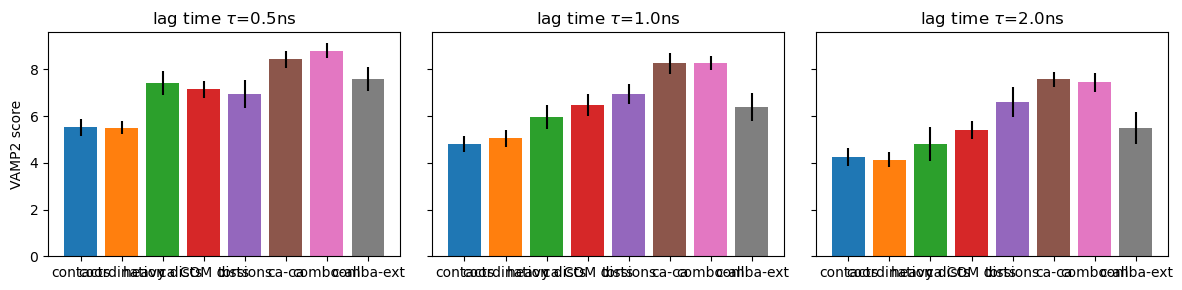

In [33]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(arr1, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    print(scores)
    positions_scores = score_cv(arr2, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(arr3, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ca_com_scores = score_cv(arr4, lag=lag, dim=dim)
    scores += [ca_com_scores.mean()]
    errors += [ca_com_scores.std()]
    torsion_scores = score_cv(arr5, lag=lag, dim=dim)
    scores += [torsion_scores.mean()]
    errors += [torsion_scores.std()]
    ca_dist_scores = score_cv(arr6, lag=lag, dim=dim)
    scores += [ca_dist_scores.mean()]
    errors += [ca_dist_scores.std()]
    combo_all_scores = score_cv(combo_all, lag=lag, dim=dim)
    scores += [combo_all_scores.mean()]
    errors += [combo_all_scores.std()]
    combo_ext_scores = score_cv(combo_ext, lag=lag, dim=dim)
    scores += [combo_ext_scores.mean()]
    errors += [combo_ext_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2','C3','C4','C5','C6','C7'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:384: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, (list, tuple, _string_types)) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:388: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, _np.ndarray) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/m

KeyboardInterrupt: 

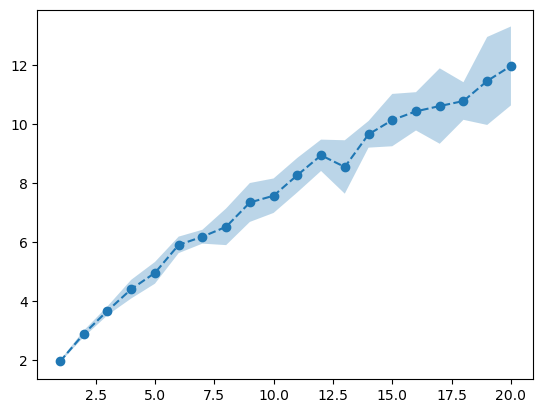

In [35]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(20)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(arr5, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [10]:
tica_dev = pyemma.coordinates.tica(arr4, lag=20)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [11]:
np.shape(arr4[0])

(10001, 14)

In [12]:
np.shape(tica_concatenated)

(98374, 9)

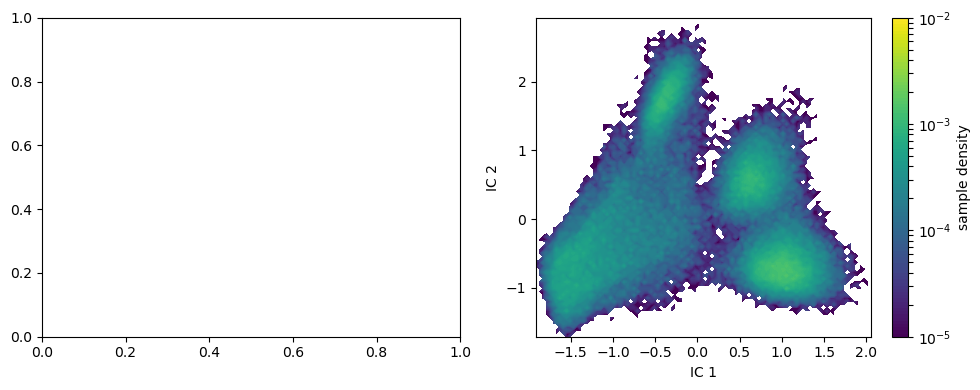

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# pyemma.plots.plot_feature_histograms(
#     tica_concatenated,
#     ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
#     ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

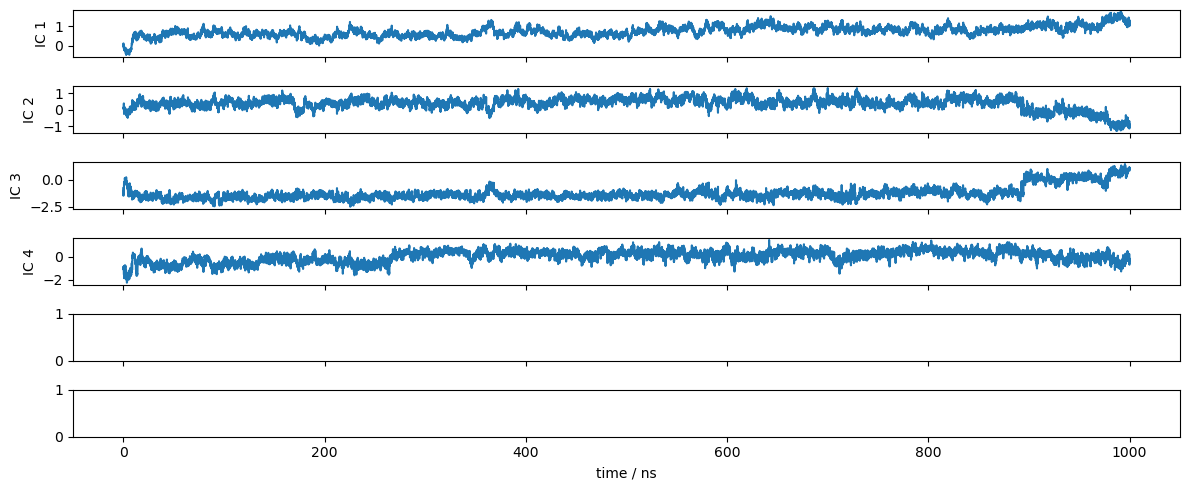

In [15]:
fig, axes = plt.subplots(6, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_out[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_out[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
# plt.savefig('ics_update.png')

In [21]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_out, k=200, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                      | 0/200 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/200 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                 | 0/9 [00:00<?, ?it/s]

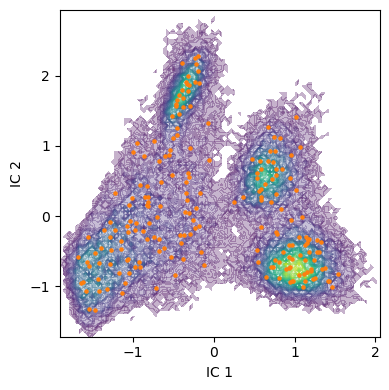

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

estimating BayesianMSM:   0%|                            | 0/14 [00:00<?, ?it/s]

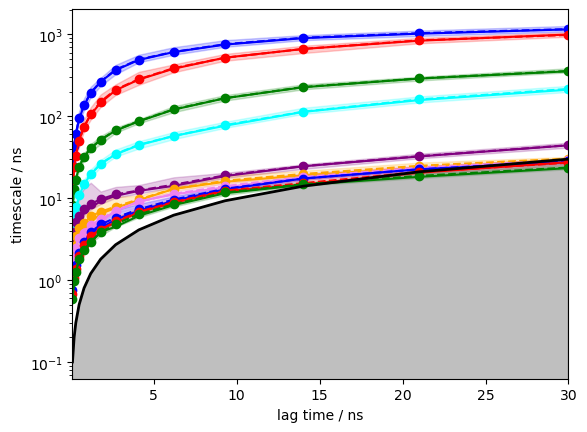

In [23]:
its = pyemma.msm.its(cluster.dtrajs, lags=300, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

In [24]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=100, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[53]: compute stat. inefficiencies

pyemma.msm.estimators.bayesian_msm.BayesianMSM[53]: Sampling MSMs:   0%| | 0/100

fraction of states used = 1.00
fraction of counts used = 1.00


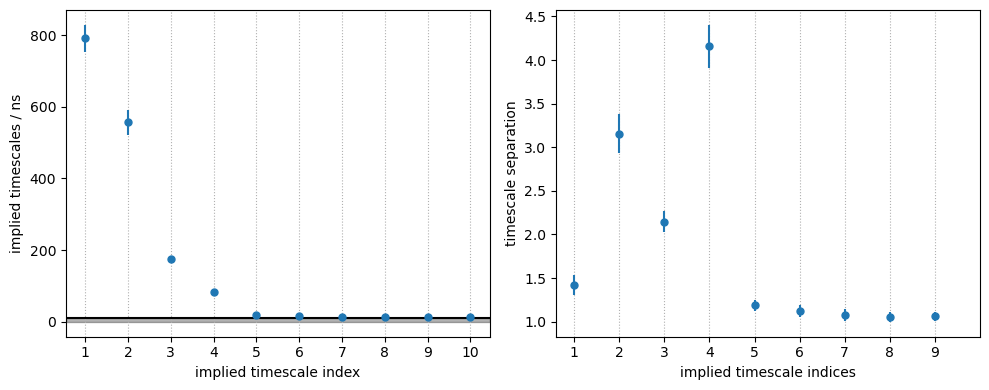

In [25]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

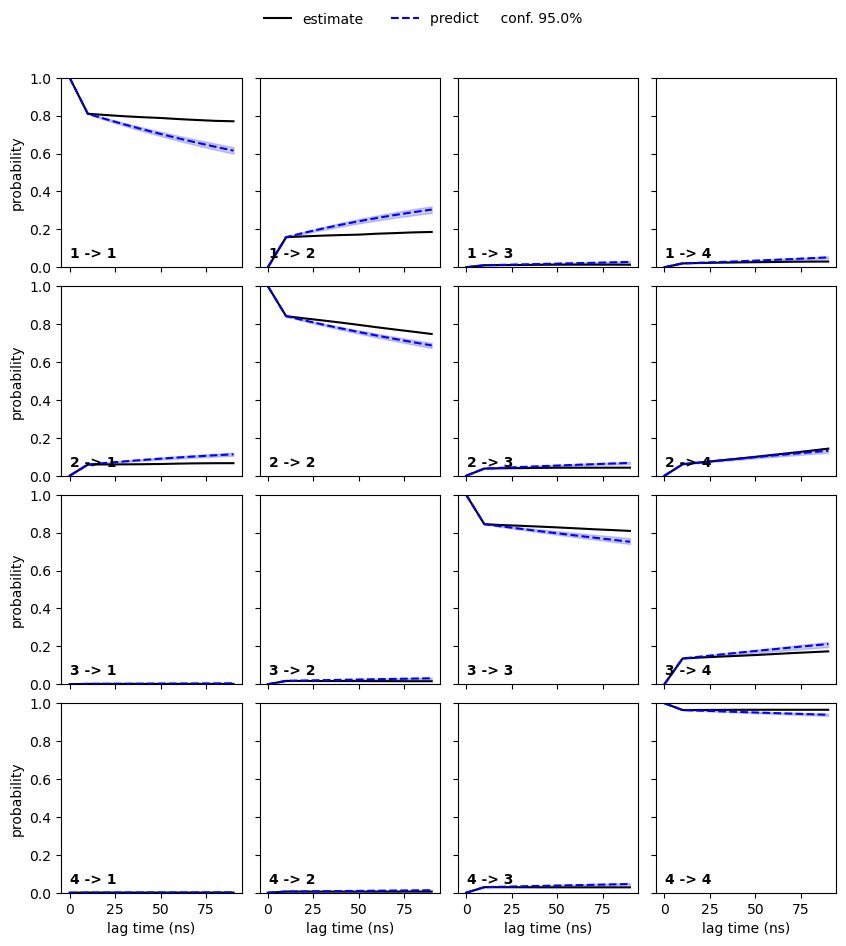

In [26]:
nstates = 4
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

In [37]:
np.shape(arr4[0])

(10001, 14)

In [30]:
np.shape(tica_out[0])


(10001, 4)

In [33]:
np.shape(tica_dev.eigenvectors)

(14, 13)

In [13]:
# Extract the eigenvectors
eigenvectors = tica_dev.eigenvectors

# Normalize the eigenvectors
eigenvectors_normalized = eigenvectors / np.sum(np.abs(eigenvectors), axis=0)
# Choose which tIC to examine, 0 corresponds to the slowest
tIC_index = 2

# Get the weights for this tIC
weights = eigenvectors_normalized[:, tIC_index]

# If you have names for your 14 features you could pair them up with the weights for easier interpretation
feature_names = ['a','b','c','d','e','f','g','h','i','f','k','l','m','n']  # replace with your list of feature names

# Make a dictionary of feature names and weights
feature_weights = dict(zip(feature_names, weights))

# Sort dictionary by absolute weight
feature_weights_sorted = sorted(feature_weights.items(), key=lambda item: abs(item[1]), reverse=True)

# Print the features and their weights, in descending order of weight
for feature, weight in feature_weights_sorted:
    print(f"{feature}: {weight}")


i: 0.26371420760417263
c: -0.2342531989265104
l: -0.13920705058248875
m: 0.11045497663331284
k: 0.09313137525604641
n: -0.048790135106755124
g: 0.03196709800411069
b: -0.026440778791803395
f: -0.019877911720815055
h: -0.011756655364279922
e: 0.011140436904826473
d: -0.009243041630756146
a: 1.7183329285729032e-06


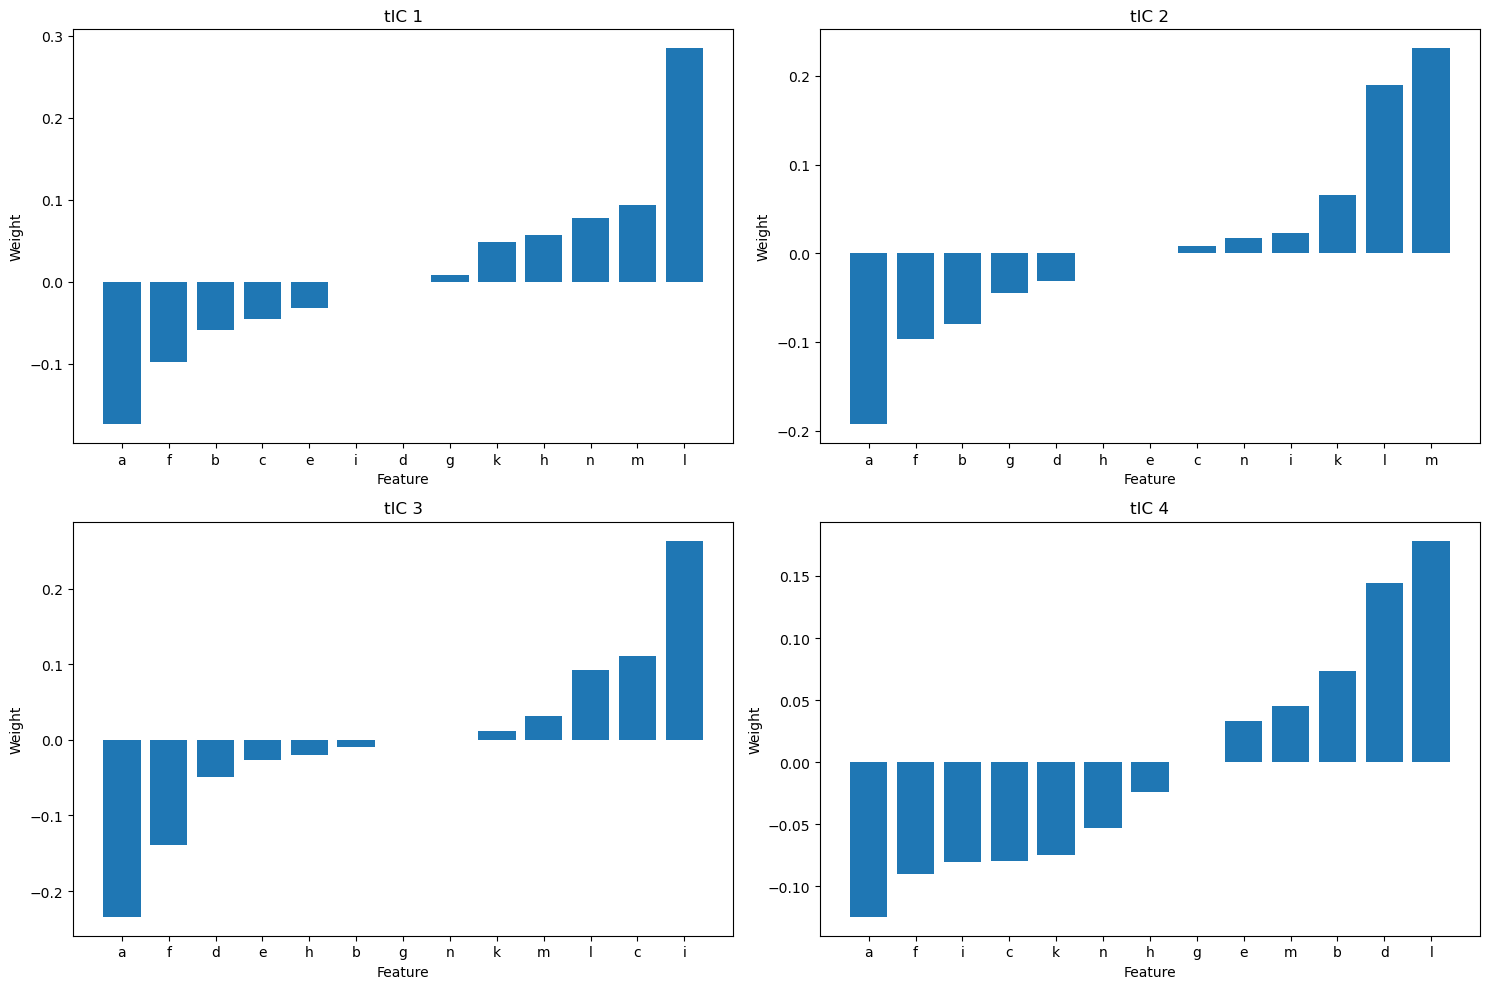

In [14]:
import matplotlib.pyplot as plt

# Extract the weights for the first four tICs
weights_tICs = eigenvectors_normalized[:, :4]

# Generate four subplots, one for each tIC
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Reshape axs to be one-dimensional
axs = axs.flatten()

# Loop over each tIC
for i in range(4):
    # Sort features by absolute weight for the i-th tIC
    sorted_features = [x for _, x in sorted(zip(np.abs(weights_tICs[:, i]), feature_names))]
    sorted_weights = sorted(weights_tICs[:, i])
    
    # Plot the weights of each feature
    axs[i].bar(sorted_features, sorted_weights)
    
    # Set the title
    axs[i].set_title(f'tIC {i+1}')
    
    # Set the x-axis label
    axs[i].set_xlabel('Feature')
    
    # Set the y-axis label
    axs[i].set_ylabel('Weight')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
np.sum(eigenvectors[12])

93.95373761410274

In [16]:
ab=abs(eigenvectors_normalized)

In [17]:
(eigenvectors_normalized)

array([[ 7.47628338e-06,  5.80840849e-06,  1.71833293e-06,
         1.33061442e-05,  4.15380681e-06, -1.34219052e-05,
         1.87847445e-06, -5.07684651e-06,  7.71189116e-06,
         3.85468090e-06, -8.42212026e-06, -2.62679477e-02,
         2.77583680e-03],
       [ 8.68375323e-03,  8.25499770e-03, -2.64407788e-02,
        -1.24486608e-01,  1.41745507e-01, -1.11096354e-02,
        -1.41537696e-01, -3.02680666e-02,  8.26021140e-02,
         3.80814925e-02,  3.16708500e-03, -7.02113094e-03,
        -9.48518637e-03],
       [-1.99434299e-02,  6.54930227e-02, -2.34253199e-01,
         3.35863979e-02, -5.86123989e-03,  4.29297111e-02,
         2.37157956e-02, -8.67751846e-03,  7.69082430e-02,
        -6.79411904e-02, -2.54738487e-02,  1.89642938e-02,
        -1.85808480e-02],
       [ 5.67661322e-02, -1.93712694e-02, -9.24304163e-03,
         1.43947205e-01, -1.16332843e-01, -1.54107768e-01,
         2.02441275e-03,  8.65428290e-02,  2.48963241e-01,
         1.47373859e-01,  2.88758496e

In [18]:
# assuming `eigenvectors_normalized` is your normalized eigenvectors matrix

# compute sum of absolute values in each column
column_sums = np.sum(np.abs(eigenvectors_normalized), axis=0)

# print the sums
print(column_sums)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
weights_tIC1 = eigenvectors[:, 0]

In [20]:
weights_tIC1

array([ 1.19233460e-03,  1.38490463e+00, -3.18062336e+00,  9.05319133e+00,
       -5.05056383e+00,  9.03766184e-03, -9.48581093e+00,  1.49686461e+01,
        7.73862320e+00, -7.26142161e+00,  1.24503982e+01,  4.54507290e+01,
       -2.77617639e+01, -1.56853586e+01])

In [21]:
weights_tIC12 = eigenvectors[:, 1]

In [22]:
weights_tIC12

array([ 1.95738033e-03,  2.78185843e+00,  2.20705473e+01, -6.52793993e+00,
       -1.51460694e+01,  3.85091252e-03,  5.93212958e+00, -1.03682678e+01,
       -3.25664892e+01,  7.70234656e+00,  6.40138595e+01, -6.50144836e+01,
        7.79530157e+01, -2.69080030e+01])

In [23]:
eigenvalues = tica_dev.eigenvalues


In [24]:
implied_timescales = -20 / np.log(eigenvalues)


In [25]:
implied_timescales

array([754.76195719, 246.49275654, 185.11771865,  76.7009699 ,
        50.96546377,  43.99432408,  35.03033059,  33.97490531,
        25.65241176,  21.67611009,  12.67910989,   4.58232457,
         4.31113839])

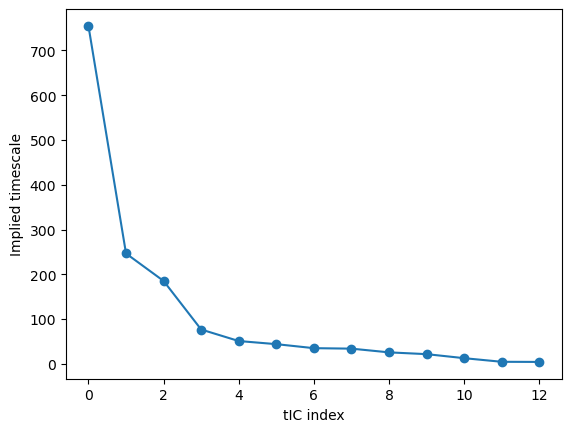

In [26]:
# Plot the implied timescales
plt.plot(implied_timescales, 'o-')
plt.xlabel('tIC index')
plt.ylabel('Implied timescale')
plt.show()


In [27]:
tica_concatenated[:,0]

array([ 0.0344304 ,  0.11694617, -0.07552574, ...,  1.1859256 ,
        1.1594409 ,  1.1086286 ], dtype=float32)

getting output of TICA:   0%|                                                                                 …

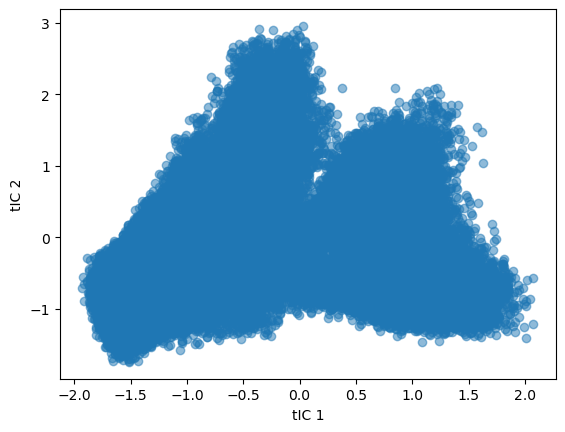

In [28]:
import matplotlib.pyplot as plt

# project data onto the first two tICs
tica_proj = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_proj)

plt.figure()
plt.scatter(tica_concatenated[:, 0], tica_concatenated[:, 1], alpha=0.5)
plt.xlabel('tIC 1')
plt.ylabel('tIC 2')
plt.show()


In [29]:
import nglview as nv


In [30]:
view = nv.show_structure_file('../traj_dat/10.gro')

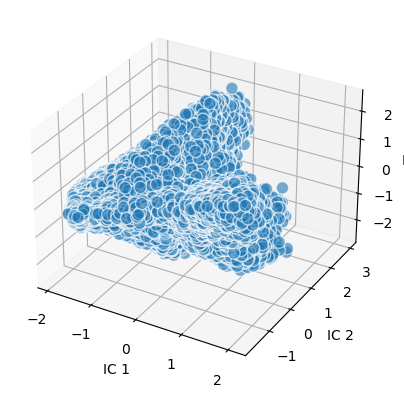

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming tica_concatenated is your tICA result, and you're taking the first three dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]
z = tica_concatenated[:, 2]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, alpha=0.6, edgecolors='w', s=80)

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_zlabel('IC 3')

plt.show()


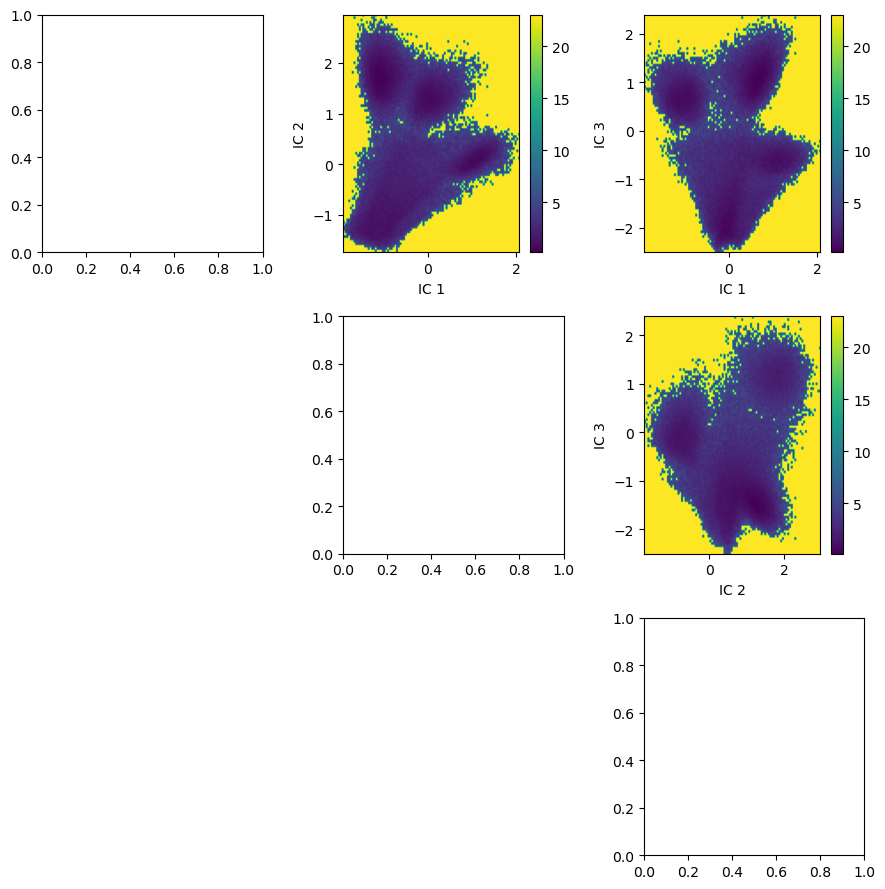

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tica_concatenated is your tICA result, and you're taking the first three dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]
z = tica_concatenated[:, 2]

# Create a grid of plots
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

# List of pairs of indices to iterate over
pairs = [(0, 1), (0, 2), (1, 2)]

# List of data vectors
data_vectors = [x, y, z]

# Iterate over pairs of indices
for i, (idx1, idx2) in enumerate(pairs):
    # Compute 2D histogram
    hist, xedges, yedges = np.histogram2d(data_vectors[idx1], data_vectors[idx2], bins=100, density=True)
    
    # Convert histogram to free energy
    free_energy = -np.log(hist + 1e-10)
    
    # Plot
    c = axs[idx1, idx2].imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='viridis')
    
    # Add colorbar
    plt.colorbar(c, ax=axs[idx1, idx2])

    axs[idx1, idx2].set_xlabel(f'IC {idx1 + 1}')
    axs[idx1, idx2].set_ylabel(f'IC {idx2 + 1}')

# Hide unused subplots
for i in range(3):
    for j in range(i+1, 3):
        fig.delaxes(axs[j, i])

plt.tight_layout()
plt.show()


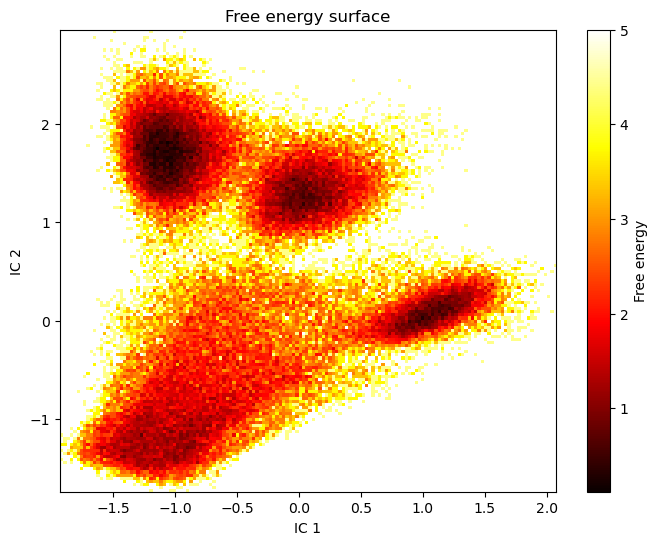

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tica_concatenated is your tICA result, and you're taking the first two dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=150, density=True)
    
# Convert histogram to free energy
free_energy = -np.log(hist + 1e-10)
    
# Create a new figure
plt.figure(figsize=(8, 6))

# Plot free energy surface with the 'viridis' colormap
plt.imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='hot',vmax=5)

# Add colorbar
plt.colorbar(label='Free energy')

plt.xlabel('IC 1')
plt.ylabel('IC 2')

plt.title('Free energy surface')

plt.show()


NameError: name 'dense_bins_indices' is not defined

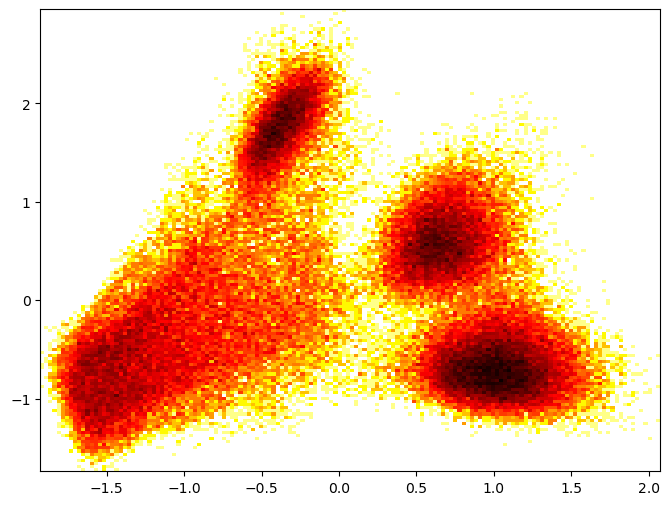

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tica_concatenated is your tICA result, and you're taking the first two dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=150, density=True)
hist = hist.T
# Convert histogram to free energy
free_energy = -np.log(hist + 1e-10)

# Identify points below a certain free energy level
threshold = 3  # define a threshold of free energy

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot free energy surface with the 'viridis' colormap
plt.imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='hot',vmax=5)

# Identify the bins that correspond to a free energy below the threshold
dense_bins = free_energy < threshold

# Get the indices of the x and y coordinates that fall into the dense bins
x_indices = np.digitize(x, xedges[:-1]) - 1  # we subtract 1 because numpy's digitize function uses 1-based indexing
y_indices = np.digitize(y, yedges[:-1]) - 1

# Get the indices of the frames that are within the dense bins
dense_frame_indices = dense_bins[y_indices, x_indices]

# Plot these points
plt.scatter(x[dense_frame_indices], y[dense_frame_indices], color='b')

# Add colorbar
plt.colorbar(label='Free energy')

plt.xlabel('IC 1')
plt.ylabel('IC 2')

plt.title('Free energy surface')

plt.show()


/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_3294954/3320175696.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


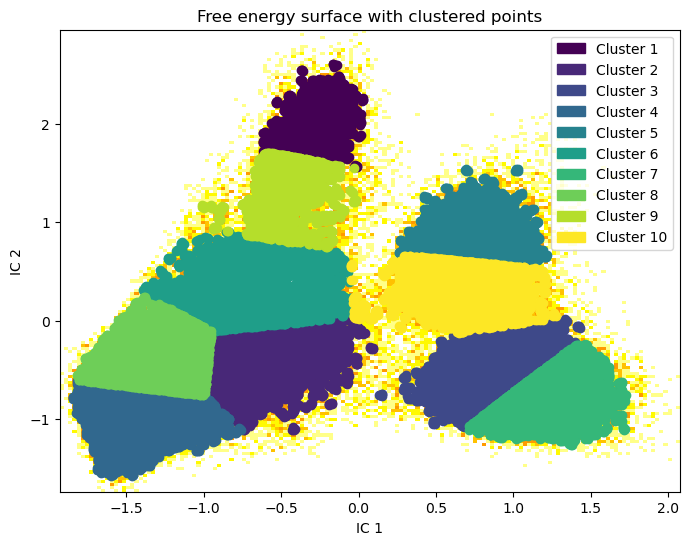

In [84]:
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

# Create an array of the dense points
dense_points = np.array([x[dense_frame_indices], y[dense_frame_indices]]).T

# Define the number of clusters
n_clusters = 10

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dense_points)

# Get the cluster labels for each point
labels = kmeans.labels_

# Create a color map
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Create a new figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the free energy surface
ax.imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='hot', vmax=5)

# Create list for legend handles
legend_handles = []

# Loop over each cluster and plot
for i in range(n_clusters):
    cluster_points = dense_points[labels == i]
    scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(i)], label=f'Cluster {i+1}')
    legend_handles.append(mpatches.Patch(color=cmap(i), label=f'Cluster {i+1}'))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_title('Free energy surface with clustered points')

# Add legend using the handles
ax.legend(handles=legend_handles)

plt.show()


In [36]:
dense_points

array([[ 0.5332854 ,  0.52883893],
       [ 0.5756515 ,  0.39556718],
       [ 0.49695215,  0.3311803 ],
       ...,
       [ 1.1859256 , -0.6123144 ],
       [ 1.1594409 , -0.65917957],
       [ 1.1086286 , -0.8929695 ]], dtype=float32)

In [37]:
tic_means = []
for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    tic_means.append(np.mean(tica_concatenated[dense_frame_indices][cluster_indices], axis=0))


In [38]:
tic_means

[array([ 1.0009793 , -0.7309813 ,  0.6105062 ,  0.03904045,  0.02843128,
        -0.03422448, -0.00800243, -0.00992882,  0.0126975 ], dtype=float32),
 array([-0.38139203,  1.7649597 ,  1.1930562 , -0.02116954,  0.28595433,
         0.03842026,  0.03734173, -0.17870758, -0.06872391], dtype=float32),
 array([ 0.63590455,  0.5603104 , -1.4881376 ,  0.1562686 ,  0.14835331,
         0.14778616, -0.03918317, -0.05050779, -0.00379005], dtype=float32),
 array([-1.5168488 , -0.7431914 , -0.12651409,  0.3601918 ,  0.3192357 ,
        -0.20300473, -0.19144708, -0.15092018, -0.06153021], dtype=float32)]

In [39]:
# Convert to a numpy array for easier manipulation
tic_means = np.array(tic_means)

# Calculate the difference in tIC means between clusters
tic_differences = np.diff(tic_means, axis=0)

# Find the tIC with the largest difference between clusters
max_diff_tic = np.argmax(np.abs(tic_differences), axis=1)

print("tICs with largest differences between clusters:", max_diff_tic)

tICs with largest differences between clusters: [1 2 0]


In [40]:
from sklearn.metrics import pairwise_distances

# Create an array that only contains the dense frames in tICA space
tica_concatenated_dense = tica_concatenated[dense_frame_indices]

# Get the cluster means for each tIC
cluster_means = np.array([np.mean(tica_concatenated_dense[labels == i], axis=0) for i in range(n_clusters)])

# Compute pairwise differences between clusters
pairwise_diff = pairwise_distances(cluster_means)

# For each pair of clusters, identify the tICs that contribute most to their difference
for i in range(n_clusters):
    for j in range(i+1, n_clusters):
        # Compute absolute difference in means along each tIC
        diff_means = np.abs(cluster_means[i] - cluster_means[j])
        # Identify the tICs that contribute most to the difference
        tICs_largest_diff = np.argsort(diff_means)[::-1]
        print(f"Between clusters {i+1} and {j+1}, the tICs with the largest differences are:")
        print(tICs_largest_diff)


Between clusters 1 and 2, the tICs with the largest differences are:
[1 0 2 4 7 8 5 3 6]
Between clusters 1 and 3, the tICs with the largest differences are:
[2 1 0 5 4 3 7 6 8]
Between clusters 1 and 4, the tICs with the largest differences are:
[0 2 3 4 6 5 7 8 1]
Between clusters 2 and 3, the tICs with the largest differences are:
[2 1 0 3 4 7 5 6 8]
Between clusters 2 and 4, the tICs with the largest differences are:
[1 2 0 3 5 6 4 7 8]
Between clusters 3 and 4, the tICs with the largest differences are:
[0 2 1 5 3 4 6 7 8]


In [156]:
features_cont = np.concatenate(arr4) 

In [158]:
np.shape(features_cont)

(98374, 14)

In [159]:
np.shape(tica_concatenated)

(98374, 9)

In [161]:
import numpy as np

# Assume `features` is a 2D array, with each row representing a frame and each column a feature
# tica_concatenated is your tICA results

# Transpose `features` and `tica_concatenated` so that each row is a feature/tIC and each column is a frame
features_transposed = np.transpose(features_cont)
tica_transposed = np.transpose(tica_concatenated)

# Compute correlation between features and tICs
correlations = np.corrcoef(features_transposed, tica_transposed)

# `correlations` is now a 2D array where the element at (i, j) is the correlation between feature i and tIC j

# Now, we will split the correlation matrix into feature-feature, feature-tIC, tIC-feature, and tIC-tIC
n_features = features_cont.shape[1]
n_tics = tica_concatenated.shape[1]

# The correlation between features and tICs is in the upper right quadrant of the correlation matrix
feature_tIC_correlations = correlations[:n_features, n_features:]


In [162]:
feature_tIC_correlations

array([[-2.14986472e-02, -2.00985294e-02, -6.55877404e-03,
         1.44472074e-02,  2.23587355e-02, -1.13941241e-02,
        -2.24159280e-03, -1.29862348e-02, -7.83293756e-03],
       [ 9.10152010e-01,  4.89600052e-02, -1.67128435e-01,
        -3.69430732e-01, -1.85500798e-02, -3.84407297e-02,
         1.31776148e-02, -3.07553005e-02,  3.15778889e-02],
       [ 9.18099296e-01,  1.53189927e-01, -1.58395568e-01,
        -1.40545747e-01, -1.52422708e-02,  1.85859736e-01,
         1.85306318e-01, -6.07741587e-02,  1.20031162e-01],
       [ 9.10745606e-01,  3.29078686e-01,  3.02524791e-03,
        -7.90821518e-02, -2.14436273e-01, -5.68926350e-02,
        -4.30883890e-02,  5.68680617e-02,  2.87707429e-02],
       [ 7.10122615e-01,  5.12065750e-01,  1.77352771e-01,
        -1.21456032e-01, -3.70997808e-01,  1.13055001e-01,
        -1.89881244e-01,  1.71735131e-02,  9.92427500e-04],
       [ 5.20240161e-02,  2.12026390e-02,  7.45136534e-03,
         2.65000349e-02,  2.78607741e-02, -1.256305

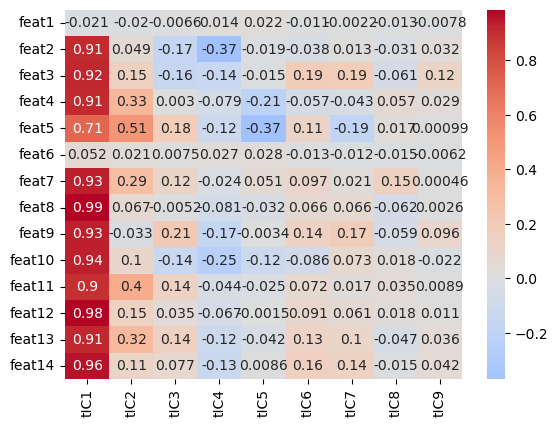

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using the feature_tIC_correlations array computed in the previous code block

# Create a heatmap
sns.heatmap(feature_tIC_correlations, cmap='coolwarm', center=0, annot=True)

# You can add feature and tIC labels if you have them
feature_names = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'feat13', 'feat14']
tIC_names = ['tIC1', 'tIC2', 'tIC3', 'tIC4', 'tIC5', 'tIC6', 'tIC7', 'tIC8', 'tIC9']

# Set the labels
plt.yticks(np.arange(len(feature_names))+0.5, feature_names, rotation=0)
plt.xticks(np.arange(len(tIC_names))+0.5, tIC_names, rotation=90)

plt.show()


In [170]:
# Compute correlation between tICs and features
correlation = np.corrcoef(tica_concatenated.T, features_cont.T)

# Select the correlations between tICs and the first 15 features
tic_feature_corr = correlation[:10, 10:24]

In [41]:
tlist=['../../trajdat/dat2/rep1_tot.xtc','../../trajdat/dat2/rep2_tot.xtc','../../trajdat/dat2/rep3_tot.xtc',\
       '../../trajdat/dat2/rep4.xtc','../../trajdat/dat2/rep6_tot2.xtc','../../trajdat/dat/1_tot.xtc','../../trajdat/dat/3_tot.xtc',\
        '../../trajdat/dat/5_tot.xtc','../../trajdat/dat/9_tot.xtc']

In [173]:
cluster_indices

array([ 2243,  2244,  2245,  2246,  2247,  2248,  2249,  2250,  2251,
        2252,  2253,  2254,  2255,  2256,  2257,  2258,  2259,  2260,
        2261,  2262,  2263,  2264,  2265,  2266,  2267,  2268,  2269,
        2270,  2271,  2272,  2273,  2274,  2275,  2276,  2277,  2278,
        2279,  2280,  2281,  2282,  2283,  2284,  2285,  2286,  2287,
        2288,  2289,  2290,  2291,  2292,  2293,  2294,  2295,  2296,
        2297,  2298,  2299,  2300,  2301,  2302,  2303,  2304,  2305,
        2306,  2307,  2308,  2309,  2310,  2311,  2312,  2313,  2314,
        2315,  2316,  2317,  2318,  2319,  2320,  2321,  2322,  2323,
        2324,  2325,  2326,  2327,  2328,  2329,  2330,  2331,  2332,
        2333,  2334,  2335,  2336,  2337,  2339,  2340,  2341,  2342,
        2343,  2344,  2345,  2346,  2347,  2348,  2349,  2350,  2351,
        2352,  2353,  2354,  2355,  2356,  2357,  2358,  2359,  2360,
        2361,  2362,  2363,  2364,  2365,  2366,  2367,  2368,  2369,
        2370,  2371,

In [194]:
from pyemma.coordinates import source, save_trajs

In [221]:
print(f"Shape of labels: {labels.shape}")
print(f"Shape of dense_frame_indices: {dense_frame_indices.shape}")


Shape of labels: (22474,)
Shape of dense_frame_indices: (22474,)


In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

# Assuming tica_concatenated is your tICA result, and you're taking the first two dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=150, density=True)
hist = hist.T
# Convert histogram to free energy
free_energy = -np.log(hist + 1e-10)

# Identify points below a certain free energy level
threshold = 1  # define a threshold of free energy

# Identify the bins that correspond to a free energy below the threshold
dense_bins = free_energy < threshold

# Get the indices of the x and y coordinates that fall into the dense bins
x_indices = np.digitize(x, xedges[:-1]) - 1  # we subtract 1 because numpy's digitize function uses 1-based indexing
y_indices = np.digitize(y, yedges[:-1]) - 1

# Get the indices of the frames that are within the dense bins
dense_frame_indices = np.where(dense_bins[y_indices, x_indices])[0]
print(dense_frame_indices)
print(dense_frame_indices.shape)
# Create an array of the dense points
dense_points = tica_concatenated[dense_frame_indices]

# Define the number of clusters
n_clusters = 4

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dense_points)

# Get the cluster labels for each point
labels = kmeans.labels_


[   96   114   117 ... 98371 98372 98373]
(22474,)


/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [95]:
# Get the cumulative number of frames at the end of each trajectory
cumulative_frames = np.cumsum(torsions_source.trajectory_lengths())

# Initiate list to hold the sample frames
sample_frames = []

# For each cluster
for i in range(n_clusters):
    # Get the indices of the dense points that belong to this cluster
    cluster_dense_indices = np.where(labels == i)[0]

    # Convert these indices into frame indices
    cluster_frame_indices = dense_frame_indices[cluster_dense_indices]

    # Select a subset of frames to save
    if cluster_frame_indices.size >= 10:
        sample_indices = np.random.choice(cluster_frame_indices, size=10, replace=False)
    else:
        sample_indices = cluster_frame_indices

    # Convert frame indices to pairs of trajectory index and frame index within trajectory
    traj_indices = np.digitize(sample_indices, cumulative_frames) - 1
    # correct the frame indices to be within each trajectory
    frame_indices = sample_indices - np.insert(cumulative_frames, 0, 0)[traj_indices]

    # Save these pairs to sample_frames
    sample_frames.append(np.column_stack((traj_indices, frame_indices)))




In [93]:
# Create a dictionary to store each cluster's original indices
cluster_to_indices = {}

# Loop through each unique label (i.e., each cluster)
for cluster_id in np.unique(labels):
    # Initialize an empty list to store this cluster's indices
    cluster_to_indices[cluster_id] = []
    
    # Get the data points belonging to this cluster
    cluster_points = dense_points[labels == cluster_id]
    
    # Loop through each data point in this cluster
    for point in cluster_points:
        # Find the index of this data point in the original `tica_concatenated` array
        # (We use np.all to compare two arrays element-wise)
        original_index = np.where(np.all(tica_concatenated == point, axis=1))[0]
        
        # Add the original index to this cluster's list of indices
        cluster_to_indices[cluster_id].extend(original_index)

# Now `cluster_to_indices` is a dictionary mapping each cluster ID to a list of the original indices of its data points


In [94]:
cluster_to_indices

{0: [3633,
  3639,
  9009,
  9049,
  9050,
  9058,
  9060,
  9062,
  9073,
  9090,
  9105,
  9148,
  9163,
  9178,
  9179,
  9209,
  9216,
  9330,
  9332,
  9335,
  9343,
  9344,
  9366,
  9371,
  9412,
  9437,
  9438,
  9442,
  9540,
  9591,
  9594,
  9597,
  9604,
  9605,
  9606,
  9607,
  9617,
  9618,
  9619,
  9620,
  9622,
  9627,
  9628,
  9629,
  9639,
  9640,
  9651,
  9652,
  9654,
  9655,
  9659,
  9666,
  9670,
  9671,
  9672,
  9673,
  9693,
  9697,
  9698,
  9699,
  9704,
  9706,
  9707,
  9712,
  9713,
  9723,
  9724,
  9733,
  9738,
  9742,
  9743,
  9750,
  9751,
  9755,
  9756,
  9760,
  9770,
  9793,
  9794,
  9795,
  9796,
  9810,
  9819,
  9822,
  9826,
  9829,
  9830,
  9831,
  9832,
  9836,
  9838,
  9839,
  9871,
  9873,
  9892,
  9936,
  9941,
  9946,
  9947,
  9952,
  9954,
  9955,
  9958,
  9960,
  9961,
  9965,
  9966,
  9967,
  9968,
  9969,
  9970,
  9971,
  9972,
  9973,
  9974,
  9975,
  9976,
  9978,
  9979,
  9980,
  9981,
  9982,
  9983,
  9984,
  998

In [68]:
# Load the original trajectories
topology_file = '../../trajdat/dat/gro.gro'  # Replace with the path to your topology file
universe = mda.Universe(topology_file, tlist)


In [78]:
import MDAnalysis as mda

# Your list of trajectory files

tlist=['../../trajdat/dat2/rep1_tot.xtc','../../trajdat/dat2/rep2_tot.xtc','../../trajdat/dat2/rep3_tot.xtc',\
       '../../trajdat/dat2/rep4.xtc','../../trajdat/dat2/rep6_tot2.xtc','../../trajdat/dat/1_tot.xtc','../../trajdat/dat/3_tot.xtc',\
        '../../trajdat/dat/5_tot.xtc','../../trajdat/dat/9_tot.xtc']
# Load the original trajectories
topology_file = '../../trajdat/dat/gro.gro'  # Replace with the path to your topology file
universe = mda.Universe(topology_file, tlist)

# Number of representative structures per cluster
n_representatives = 20  # You may adjust this

# Iterate over each cluster and select representative structures
for cluster_id, cluster_indices in cluster_to_indices.items():
    # If a cluster has fewer frames than n_representatives, take all of them
    if len(cluster_indices) < n_representatives:
        selected_indices = cluster_indices
    else:  # Otherwise, select a random sample
        selected_indices = np.random.choice(cluster_indices, n_representatives, replace=False)
        print(selected_indices)
    
    for i, frame_idx in enumerate(selected_indices):
        universe.trajectory[frame_idx]
        output_filename = f'./cluster_{cluster_id + 1}_structure_{i + 1}.gro'
        universe.atoms.write(output_filename)


[83051 83236 79568 81850 73789 24970 79922 27050 83648 11059 76738 80576
  9707 26641 28176 26413 25809 83277 79027 80515]
[43760 43649 40424 42857 48537 47857 43003 52545 40781 43642 46725 44859
 45106 41672 42846 50718 43005 50605 45588 50738]
[ 1432  1647 36071 38513  2345  6676  1032 33513  3546  2212 35288  7406
 35066 31840  2153  4791  4181 36535  5176  1798]
[93152 91597 95798 95463 95256 94061 96021 94481 63656 94044 62413 92204
 63946 95570 96772 92100 62544 96234 93967 93888]


In [86]:
import os
import shutil
import MDAnalysis as mda

# Define the output directory
output_dir = 'gro'

# If the directory already exists, remove it
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# Create the directory
os.makedirs(output_dir)

tlist=['../../trajdat/dat2/rep1_tot.xtc','../../trajdat/dat2/rep2_tot.xtc','../../trajdat/dat2/rep3_tot.xtc',\
       '../../trajdat/dat2/rep4.xtc','../../trajdat/dat2/rep6_tot2.xtc','../../trajdat/dat/1_tot.xtc','../../trajdat/dat/3_tot.xtc',\
        '../../trajdat/dat/5_tot.xtc','../../trajdat/dat/9_tot.xtc']

# Load the original trajectories
topology_file = '../../trajdat/dat/gro.gro'  # Replace with the path to your topology file
universe = mda.Universe(topology_file, tlist)

# Number of representative structures per cluster
n_representatives = 5  # You may adjust this

# Iterate over each cluster and select representative structures
for cluster_id, cluster_indices in cluster_to_indices.items():
    # If a cluster has fewer frames than n_representatives, take all of them
    if len(cluster_indices) < n_representatives:
        selected_indices = cluster_indices
    else:  # Otherwise, select a random sample
        selected_indices = np.random.choice(cluster_indices, n_representatives, replace=False)
        print(selected_indices)
    
    for i, frame_idx in enumerate(selected_indices):
        universe.trajectory[frame_idx]
        output_filename = os.path.join(output_dir, f'cluster_{cluster_id + 1}_structure_{i + 1}.gro')
        universe.atoms.write(output_filename)


[81580 75361 95973 80620 75665]
[50969 50991 49633 43823 41583]
[35174  1251 36205  8394 33679]
[93388 94082 94050 92601 96085]
